In [1]:
import os
import numpy as np 
import utilities as utils 
import params 
# Being re-written --
# from straightening_hierarchy import Straightening_Hierarchy
# from models.steerable.config import device
device = 'cpu'
from torch.autograd import Variable

In [2]:
# save results

# savedir = 'results/'
# savedir = '%s%s-N%d-K%d-S%d/' % (savedir, params.model_name, params.N, params.K, params.imgSize)
# os.makedirs( savedir, exist_ok=True )

In [3]:
# sequenceTypes = ['groundtruth', 'pixelfade', 'contrast']
sequenceTypes = ['groundtruth']
modelStages = ['pixel', 'retina', 'v1']

In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 

import sys 
import os

from models.retinalDN.retinalDN import RetinalDN
from models.steerable.steerable_Julie import SteerablePyramid

class Straightening_Hierarchy(nn.Module):

    def __init__( self, imgSize, N, K, remove=True, square=True ):
        super(Straightening_Hierarchy, self).__init__()

        self.retinalDN = RetinalDN() 
        self.pyr = SteerablePyramid( imgSize, K=K, N=N, hilb=True )
        self.remove = remove
        self.square = square


    def compute_pyr(self, x):

        x = self.pyr( x.unsqueeze(1) )
        
        if self.remove:
            x.pop( 0 ) # remove high-pass
            x.pop(   ) # remove low-pass

        if self.square:
            for i in range( len(x) ):
                x[i] = ( x[i] ** 2 ).sum(1).select( 1, 0 ) # compute complex magnitude 
#                 x[i] = torch.sqrt(x[i])

        for i in range( len(x) ):
#             x[i] = x[i].view( x[i].size(0), -1 )
            x[i] = torch.reshape(x[i], (x[i].size()[0], -1))
                    
        return torch.cat( tuple(x), -1 ) # concatenate all pyramid bands 

    def forward(self, x):

        y = {}

        y['pixel'] = x / 255 

        y['retina'] = self.retinalDN( y['pixel'] )

        y['v1'] = self.compute_pyr( y['retina'] )

        return y

In [5]:
models = [Straightening_Hierarchy(params.imgSize, N=params.N, K=params.K, remove=True, square=True),
          Straightening_Hierarchy(params.imgSize, N=params.N, K=params.K, remove=True, square=False),
          Straightening_Hierarchy(params.imgSize, N=params.N, K=params.K, remove=False, square=True),
          Straightening_Hierarchy(params.imgSize, N=params.N, K=params.K, remove=False, square=False)]
if device == 'cuda':
	model.cuda()

In [6]:
for s, sequenceType in enumerate(sequenceTypes):
    
    curvature = {}
    for m, model in enumerate(models):
        curvature[m] = {}
        for modelStage in modelStages:
            curvature[m][modelStage] = {} 

        if sequenceType == 'contrast':
            imgNames = [ 'water-contrast0.5', 'prairieTer-contrastLog0.1', 'boats_contrastCocktail', 'bees_contrastCocktail', 'walking_contrastCocktail', 'egomotion_contrastCocktail', 'smile-contrastLog0.1', 'walking-contrast0.5', 'bees-contrast0.5', 'walking-contrastLog0.1' ]
        else:
            imgNames = [ 'water', 'prairieTer', 'boats', 'ice3', 'dogville', 'egomotion', 'walking', 'smile', 'bees', 'leaves-wind', 'carnegie-dam', 'chironomus' ]

        for i, imgName in enumerate(imgNames):

            if sequenceType == 'groundtruth':
                x = utils.makeGroundtruth(imgName) 
            elif sequenceType == 'pixelfade':
                x = utils.makePixelfade(imgName) 
            elif sequenceType == 'contrast':
                x = utils.makeContrastfade(imgName) 

            if device == 'cuda':
                x = x.cuda()
            x = Variable( x ) 
            y = model( x )

            for modelStage in modelStages:
                dY, cY = utils.computeDistCurv( y[modelStage] )
                curvature[m][modelStage][imgName] = cY.data.mean()
                
        print('Model %d: '%(m+1))
        for o, modelStage in enumerate(modelStages):	
            avPixelCurvature = np.array(list(curvature[m]['pixel'].values())).mean()
            avModelCurvature = np.array(list(curvature[m][modelStage].values())).mean()
            deltaCurvature = avModelCurvature - avPixelCurvature
            
            print('sequence type: %s \tmodel stage: %s \tdelta curvature %.2f' % (sequenceType, modelStage, deltaCurvature))

# 	np.save( savedir + 'modelCurvature_' + sequenceType + '.npy', curvature )

Model 1: 
sequence type: groundtruth 	model stage: pixel 	delta curvature 0.00
sequence type: groundtruth 	model stage: retina 	delta curvature -6.88
sequence type: groundtruth 	model stage: v1 	delta curvature -21.56
Model 2: 
sequence type: groundtruth 	model stage: pixel 	delta curvature 0.00
sequence type: groundtruth 	model stage: retina 	delta curvature -6.88
sequence type: groundtruth 	model stage: v1 	delta curvature -7.22
Model 3: 
sequence type: groundtruth 	model stage: pixel 	delta curvature 0.00
sequence type: groundtruth 	model stage: retina 	delta curvature -6.88
sequence type: groundtruth 	model stage: v1 	delta curvature -33.32
Model 4: 
sequence type: groundtruth 	model stage: pixel 	delta curvature 0.00
sequence type: groundtruth 	model stage: retina 	delta curvature -6.88
sequence type: groundtruth 	model stage: v1 	delta curvature -7.01


([<matplotlib.axis.XTick at 0x152d6d854d00>,
 [Text(0, 0, 'Pixel'),
  Text(1, 0, 'LGN'),
  Text(2, 0, 'V1-B^2'),
  Text(3, 0, 'V1-B'),
  Text(4, 0, 'V1-LBH^2'),
  Text(5, 0, 'V1-LBH')])

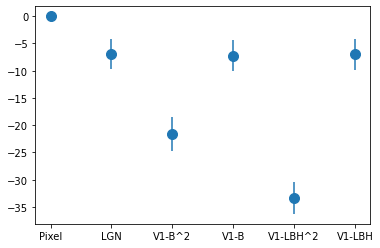

In [7]:
base = np.array(list(curvature[0]['pixel'].values())).mean()
b = [0,
    np.array(list(curvature[0]['retina'].values())).mean() - base]
for i in range(len(models)):
    b.append(np.array(list(curvature[i]['v1'].values())).mean() - base)
c = [0, 
    np.array(list(curvature[0]['retina'].values())).std()]
for i in range(len(models)):
    c.append(np.array(list(curvature[i]['v1'].values())).std())
a = np.arange(len(b))

c = np.array(c) * 0.1

import matplotlib.pyplot as plt
plt.scatter(a, b, s=100, marker='o')
plt.errorbar(a, b, yerr=c, fmt="o")
plt.xticks(a, ['Pixel', 'LGN', 'V1-B^2', 'V1-B', 'V1-LBH^2', 'V1-LBH'], fontsize=10)